In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
# Note: We use 'encoding="ISO-8859-1"' just in case, as retail data often has special characters
df = pd.read_csv('online_retail_II.csv')

# Display the first few rows to verify
print("Data Loaded Successfully:")
print(df.head())

Data Loaded Successfully:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


In [3]:
# 1. Remove rows with missing Customer ID (Essential for segmentation)
df.dropna(subset=['Customer ID'], inplace=True)

# 2. Remove cancelled orders (Invoice starts with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# 3. Keep only positive quantities
df = df[df['Quantity'] > 0]

# 4. Convert InvoiceDate to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 5. Calculate Total Price per row (Quantity * Price)
df['TotalPrice'] = df['Quantity'] * df['Price']

print(f"Cleaned Data Rows: {df.shape[0]}")

Cleaned Data Rows: 805620


In [4]:
# Set a reference date (1 day after the last transaction in the data)
reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Group by Customer ID to calculate R, F, M
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days, # Recency
    'Invoice': 'nunique',                                     # Frequency
    'TotalPrice': 'sum'                                       # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

print(rfm.head())

   Customer ID  Recency  Frequency  Monetary
0      12346.0      326         12  77556.46
1      12347.0        2          8   5633.32
2      12348.0       75          5   2019.40
3      12349.0       19          4   4428.69
4      12350.0      310          1    334.40


In [5]:
# Create labels:
# Recency: 4 is Best (Low days), 1 is Worst (High days) -> range(4, 0, -1)
# Frequency/Monetary: 1 is Worst (Low), 4 is Best (High) -> range(1, 5)

r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

# Assign scores using quantiles (qcut)
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=4, labels=r_labels).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=f_labels).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=4, labels=m_labels).astype(int)

# Create a combined RFM Score (Sum)
rfm['RFM_Sum'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

# Define Segments Function
def segment_customer(row):
    score = row['RFM_Sum']
    if score >= 11:         # Scores 11-12
        return 'Champions'
    elif score >= 9:        # Scores 9-10
        return 'Loyal Customers'
    elif score >= 7:        # Scores 7-8
        return 'Potential Loyalists'
    elif score >= 5:        # Scores 5-6
        return 'At Risk'
    else:                   # Scores 3-4
        return 'Hibernating'

# Apply segmentation
rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# Check the count of customers in each segment
print(rfm['Segment'].value_counts())

Segment
At Risk                1216
Potential Loyalists    1212
Champions              1182
Hibernating            1146
Loyal Customers        1125
Name: count, dtype: int64


/tmp/ipython-input-751531859.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Segment', data=rfm, order=rfm['Segment'].value_counts().index, palette='viridis')


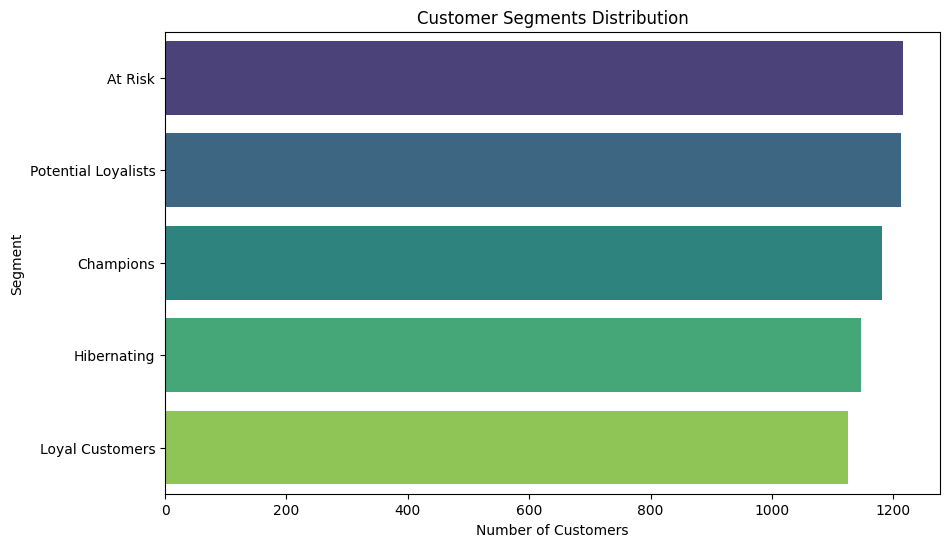

File 'rfm_segments.csv' saved successfully!


In [6]:
# 1. Bar Chart
plt.figure(figsize=(10, 6))
sns.countplot(y='Segment', data=rfm, order=rfm['Segment'].value_counts().index, palette='viridis')
plt.title('Customer Segments Distribution')
plt.xlabel('Number of Customers')
plt.ylabel('Segment')
plt.savefig('segment_chart.png') # Save the image
plt.show()

# 2. Export to CSV
rfm.to_csv('rfm_segments.csv', index=False)
print("File 'rfm_segments.csv' saved successfully!")

In [7]:
strategy_text = """
1. Champions (High Spend, Recent, Frequent)
   - Action: Offer early access to new product launches.
   - Action: Implement a "Refer a Friend" reward program.
   - Action: Send personalized thank-you notes or exclusive gifts.

2. Loyal Customers (Good Spend and Frequency)
   - Action: Upsell higher-value items based on purchase history.
   - Action: Invite to a loyalty point program to encourage retention.
   - Action: Offer free shipping thresholds to increase basket size.

3. At Risk (Used to buy often, but haven't recently)
   - Action: Send "We Miss You" emails with a limited-time discount.
   - Action: Request feedback on their last purchase experience.
   - Action: Recommend products similar to their past favorites.
"""

with open('segment_actions.txt', 'w') as f:
    f.write(strategy_text)

print("File 'segment_actions.txt' created successfully!")

File 'segment_actions.txt' created successfully!
